In [7]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt



###UP IS ORIGIN

import math
import torch.optim as optim


### SEC 3
from torchvision.utils import save_image






# custom dataloader for .npy file
class numpyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).float()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x
    
    def __len__(self):
        return len(self.data)


In [8]:
### Setting up Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Below codes activates when want to use cpu
#device = torch.device('cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1050
Memory Usage:
Allocated: 0.4 GB
Cached:    1.1 GB


In [9]:
transform       = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                            ])

print("Load traindata..")
# for training

BATCH_SIZE = 400

traindata       = np.load('train.npy')
traindataset    = numpyDataset(traindata, transform)
trainloader     = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

print("Train data is ready")


Load traindata..
Train data is ready


In [10]:
size_img = 120 * 80
size_layer_1 = 100
size_layer_2 = 50
size_layer_3 = 12
size_layer_4 = 3

class autoencoder(nn.Module):

    def __init__(self) :
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential (
            nn.Conv2d(1, 6, kernel_size = 3),
            nn.ReLU(True),
            nn.Conv2d(6, 16,kernel_size= 5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,6,kernel_size= 5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,1,kernel_size= 3),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

    
max_epochs = 10000 # For prevent system down

#5 # 6
learning_rate = 1e-3

In [14]:
model = autoencoder().cuda()
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, weight_decay=1e-3,momentum=0.9)
criterion = nn.MSELoss()

epoch_history = []
epoch_loss_history = []
epoch_loss_std_history = []
exit_flag = 0

for epoch in range(max_epochs):
    # =========== Saving Origin imgs =========== #
    if epoch == 0 :
        for data in enumerate(traindata) :
            img = torch.tensor(data[1]).cuda()
            to_img = transforms.ToPILImage()
            pic_origin = to_img(img.view(120,80).cpu())
            pic_origin.save('./mlp_img/{}_origin.jpg'.format(data[0]))

    # ================= Train ===================
    loss_logs = []
    for data in enumerate(trainloader):
        
        order = data[0]
        img = data[1].clone().detach()
   
        img = img.cuda()
     
        # Create Noisy img
        
        # Random sigma between 0.01 - 0.04
        noise_level = torch.tensor(0.01) + torch.rand(1) * 0.03
        normal_distrib = torch.distributions.Normal(torch.tensor([0.0]),noise_level)
        noise = normal_distrib.sample(img.shape).view(img.shape).cuda()
        
        noisy_img = img + noise
        
        # ===================forward=====================
        output = model(noisy_img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        loss_logs.append(loss.item())
        optimizer.step()
        
        
        # ================= This code for Debug ====================#
        if epoch == 1 :
            if order == 2 :
                to_img = transforms.ToPILImage()
                pic_origin = to_img(img[2].view(120,80).cpu())
                pic_origin.save('./train_img/{}_origin.jpg'.format(21))
                
                pic_origin = to_img(img[6].view(120,80).cpu())
                pic_origin.save('./train_img/{}_origin.jpg'.format(25))
            else :
                to_img = transforms.ToPILImage()
                pic_origin = to_img(img[3].view(120,80).cpu())
                pic_origin.save('./train_img/{}_origin.jpg'.format(42))
            
        '''        
        if order == 2 or order == 4 :
            if order == 2 :
                to_img = transforms.ToPILImage()
                
                ## 21
                pic_input = to_img(noisy_img[2].view(120,80).cpu())
                pic_input.save('./train_img/{}_{}_input.jpg'.format(21,epoch))
                 
                pic_output = to_img(output[2].view(120,80).cpu())
                pic_output.save('./train_img/{}_{}_output.jpg'.format(21,epoch))

                ## 25
                pic_input = to_img(noisy_img[6].view(120,80).cpu())
                pic_input.save('./train_img/{}_{}_input.jpg'.format(25,epoch))
                
                
                pic_output = to_img(output[6].view(120,80).cpu())
                pic_output.save('./train_img/{}_{}_output.jpg'.format(25,epoch))
            else :
                ## 42
                to_img = transforms.ToPILImage()
                pic_input = to_img(noisy_img[3].view(120,80).cpu())
                pic_input.save('./train_img/{}_{}_input.jpg'.format(42,epoch))
                
                
                pic_output = to_img(output[3].view(120,80).cpu())
                pic_output.save('./train_img/{}_{}_output.jpg'.format(42,epoch))
        '''
    epoch_loss = np.mean(loss_logs)
    epoch_loss_std = np.std(loss_logs)
        
    # ===================log========================
    print('[epoch {}], loss: (training) {:.10f}'
          .format(epoch, epoch_loss))
    
    
    # ================ loss diff check ============
    epoch_loss_history.append(epoch_loss)
    epoch_loss_std_history.append(epoch_loss_std)
    epoch_history.append(epoch)
    
    if epoch != 0 :
        loss_diff = abs(epoch_loss_history[epoch] - epoch_loss_history[epoch-1])
        if loss_diff <= 0.0000001 and epoch_loss_history[epoch-1] < 0.0004 :
            exit_flag += 1
            if exit_flag >= 2 :
                break
        else :
            exit_flag = 0
        

[epoch 0], loss: (training) 0.1470126733
[epoch 1], loss: (training) 0.0719894492
[epoch 2], loss: (training) 0.0214485362
[epoch 3], loss: (training) 0.0217661643
[epoch 4], loss: (training) 0.0173324089
[epoch 5], loss: (training) 0.0171624693
[epoch 6], loss: (training) 0.0164761721
[epoch 7], loss: (training) 0.0162525871
[epoch 8], loss: (training) 0.0159885535
[epoch 9], loss: (training) 0.0157761224
[epoch 10], loss: (training) 0.0155446167
[epoch 11], loss: (training) 0.0153444006
[epoch 12], loss: (training) 0.0151445778
[epoch 13], loss: (training) 0.0149209962
[epoch 14], loss: (training) 0.0147308032
[epoch 15], loss: (training) 0.0145320196
[epoch 16], loss: (training) 0.0143496111
[epoch 17], loss: (training) 0.0141560512
[epoch 18], loss: (training) 0.0139882880
[epoch 19], loss: (training) 0.0138131938
[epoch 20], loss: (training) 0.0136364861
[epoch 21], loss: (training) 0.0134649987
[epoch 22], loss: (training) 0.0133057022
[epoch 23], loss: (training) 0.0131366065
[e

[epoch 194], loss: (training) 0.0035205568
[epoch 195], loss: (training) 0.0035211988
[epoch 196], loss: (training) 0.0035030845
[epoch 197], loss: (training) 0.0034998464
[epoch 198], loss: (training) 0.0034996821
[epoch 199], loss: (training) 0.0034887214
[epoch 200], loss: (training) 0.0034782593
[epoch 201], loss: (training) 0.0034784826
[epoch 202], loss: (training) 0.0034606736
[epoch 203], loss: (training) 0.0034668233
[epoch 204], loss: (training) 0.0034658485
[epoch 205], loss: (training) 0.0034569583
[epoch 206], loss: (training) 0.0034524902
[epoch 207], loss: (training) 0.0034350361
[epoch 208], loss: (training) 0.0034304435
[epoch 209], loss: (training) 0.0034237388
[epoch 210], loss: (training) 0.0034189927
[epoch 211], loss: (training) 0.0034119844
[epoch 212], loss: (training) 0.0034110175
[epoch 213], loss: (training) 0.0034013528
[epoch 214], loss: (training) 0.0033964758
[epoch 215], loss: (training) 0.0033976694
[epoch 216], loss: (training) 0.0033870919
[epoch 217]

[epoch 385], loss: (training) 0.0026040074
[epoch 386], loss: (training) 0.0026063068
[epoch 387], loss: (training) 0.0025988162
[epoch 388], loss: (training) 0.0025935050
[epoch 389], loss: (training) 0.0025741643
[epoch 390], loss: (training) 0.0025878692
[epoch 391], loss: (training) 0.0025869399
[epoch 392], loss: (training) 0.0025731666
[epoch 393], loss: (training) 0.0025678923
[epoch 394], loss: (training) 0.0025543812
[epoch 395], loss: (training) 0.0025557486
[epoch 396], loss: (training) 0.0025511568
[epoch 397], loss: (training) 0.0025600731
[epoch 398], loss: (training) 0.0025528101
[epoch 399], loss: (training) 0.0025667536
[epoch 400], loss: (training) 0.0025587787
[epoch 401], loss: (training) 0.0025519893
[epoch 402], loss: (training) 0.0025487116
[epoch 403], loss: (training) 0.0025462508
[epoch 404], loss: (training) 0.0025383318
[epoch 405], loss: (training) 0.0025530591
[epoch 406], loss: (training) 0.0025390598
[epoch 407], loss: (training) 0.0025269941
[epoch 408]

[epoch 576], loss: (training) 0.0021977773
[epoch 577], loss: (training) 0.0021968709
[epoch 578], loss: (training) 0.0022037519
[epoch 579], loss: (training) 0.0021993281
[epoch 580], loss: (training) 0.0021862356
[epoch 581], loss: (training) 0.0021743864
[epoch 582], loss: (training) 0.0021807015
[epoch 583], loss: (training) 0.0021802231
[epoch 584], loss: (training) 0.0021676281
[epoch 585], loss: (training) 0.0021756956
[epoch 586], loss: (training) 0.0021897932
[epoch 587], loss: (training) 0.0021811056
[epoch 588], loss: (training) 0.0021698050
[epoch 589], loss: (training) 0.0021693331
[epoch 590], loss: (training) 0.0021587563
[epoch 591], loss: (training) 0.0021601236
[epoch 592], loss: (training) 0.0021755728
[epoch 593], loss: (training) 0.0021682366
[epoch 594], loss: (training) 0.0021607888
[epoch 595], loss: (training) 0.0021718437
[epoch 596], loss: (training) 0.0021411465
[epoch 597], loss: (training) 0.0021504278
[epoch 598], loss: (training) 0.0021681219
[epoch 599]

[epoch 767], loss: (training) 0.0019794939
[epoch 768], loss: (training) 0.0019665452
[epoch 769], loss: (training) 0.0019759484
[epoch 770], loss: (training) 0.0019757413
[epoch 771], loss: (training) 0.0019684810
[epoch 772], loss: (training) 0.0019666030
[epoch 773], loss: (training) 0.0019686663
[epoch 774], loss: (training) 0.0019744252
[epoch 775], loss: (training) 0.0019610765
[epoch 776], loss: (training) 0.0019861561
[epoch 777], loss: (training) 0.0019660323
[epoch 778], loss: (training) 0.0019701405
[epoch 779], loss: (training) 0.0019686149
[epoch 780], loss: (training) 0.0019595978
[epoch 781], loss: (training) 0.0019444209
[epoch 782], loss: (training) 0.0019704213
[epoch 783], loss: (training) 0.0019706011
[epoch 784], loss: (training) 0.0019798201
[epoch 785], loss: (training) 0.0019835822
[epoch 786], loss: (training) 0.0019639227
[epoch 787], loss: (training) 0.0019506473
[epoch 788], loss: (training) 0.0019542821
[epoch 789], loss: (training) 0.0019646630
[epoch 790]

[epoch 958], loss: (training) 0.0018332855
[epoch 959], loss: (training) 0.0018267033
[epoch 960], loss: (training) 0.0018340133
[epoch 961], loss: (training) 0.0018195969
[epoch 962], loss: (training) 0.0018231300
[epoch 963], loss: (training) 0.0018164300
[epoch 964], loss: (training) 0.0018125739
[epoch 965], loss: (training) 0.0018220187
[epoch 966], loss: (training) 0.0018439524
[epoch 967], loss: (training) 0.0018223728
[epoch 968], loss: (training) 0.0018428576
[epoch 969], loss: (training) 0.0018226771
[epoch 970], loss: (training) 0.0018087703
[epoch 971], loss: (training) 0.0018278333
[epoch 972], loss: (training) 0.0018312668
[epoch 973], loss: (training) 0.0018248974
[epoch 974], loss: (training) 0.0018309927
[epoch 975], loss: (training) 0.0018361172
[epoch 976], loss: (training) 0.0018115293
[epoch 977], loss: (training) 0.0018352952
[epoch 978], loss: (training) 0.0018278621
[epoch 979], loss: (training) 0.0018182756
[epoch 980], loss: (training) 0.0017998258
[epoch 981]

[epoch 1146], loss: (training) 0.0017131745
[epoch 1147], loss: (training) 0.0017275208
[epoch 1148], loss: (training) 0.0017184299
[epoch 1149], loss: (training) 0.0017097694
[epoch 1150], loss: (training) 0.0017247686
[epoch 1151], loss: (training) 0.0017130812
[epoch 1152], loss: (training) 0.0017297407
[epoch 1153], loss: (training) 0.0017126974
[epoch 1154], loss: (training) 0.0017120675
[epoch 1155], loss: (training) 0.0017267300
[epoch 1156], loss: (training) 0.0017218098
[epoch 1157], loss: (training) 0.0017248452
[epoch 1158], loss: (training) 0.0017186659
[epoch 1159], loss: (training) 0.0017226427
[epoch 1160], loss: (training) 0.0017150810
[epoch 1161], loss: (training) 0.0016941430
[epoch 1162], loss: (training) 0.0017083906
[epoch 1163], loss: (training) 0.0017121793
[epoch 1164], loss: (training) 0.0017098803
[epoch 1165], loss: (training) 0.0017123933
[epoch 1166], loss: (training) 0.0017096455
[epoch 1167], loss: (training) 0.0017045144
[epoch 1168], loss: (training) 0

[epoch 1333], loss: (training) 0.0016060929
[epoch 1334], loss: (training) 0.0016193075
[epoch 1335], loss: (training) 0.0016300711
[epoch 1336], loss: (training) 0.0016240295
[epoch 1337], loss: (training) 0.0016098756
[epoch 1338], loss: (training) 0.0016204033
[epoch 1339], loss: (training) 0.0016258243
[epoch 1340], loss: (training) 0.0016186594
[epoch 1341], loss: (training) 0.0016098945
[epoch 1342], loss: (training) 0.0016157759
[epoch 1343], loss: (training) 0.0016090760
[epoch 1344], loss: (training) 0.0016097071
[epoch 1345], loss: (training) 0.0016248296
[epoch 1346], loss: (training) 0.0016309767
[epoch 1347], loss: (training) 0.0016354735
[epoch 1348], loss: (training) 0.0016315999
[epoch 1349], loss: (training) 0.0016312904
[epoch 1350], loss: (training) 0.0016229162
[epoch 1351], loss: (training) 0.0016038812
[epoch 1352], loss: (training) 0.0016119798
[epoch 1353], loss: (training) 0.0016023581
[epoch 1354], loss: (training) 0.0016043290
[epoch 1355], loss: (training) 0

[epoch 1520], loss: (training) 0.0015396106
[epoch 1521], loss: (training) 0.0015329326
[epoch 1522], loss: (training) 0.0015594837
[epoch 1523], loss: (training) 0.0015606972
[epoch 1524], loss: (training) 0.0015416040
[epoch 1525], loss: (training) 0.0015260538
[epoch 1526], loss: (training) 0.0015430819
[epoch 1527], loss: (training) 0.0015515480
[epoch 1528], loss: (training) 0.0015262118
[epoch 1529], loss: (training) 0.0015386913
[epoch 1530], loss: (training) 0.0015565922
[epoch 1531], loss: (training) 0.0015279835
[epoch 1532], loss: (training) 0.0015395526
[epoch 1533], loss: (training) 0.0015464443
[epoch 1534], loss: (training) 0.0015284752
[epoch 1535], loss: (training) 0.0015610519
[epoch 1536], loss: (training) 0.0015058402
[epoch 1537], loss: (training) 0.0015488786
[epoch 1538], loss: (training) 0.0015308512
[epoch 1539], loss: (training) 0.0015291064
[epoch 1540], loss: (training) 0.0015391345
[epoch 1541], loss: (training) 0.0015456831
[epoch 1542], loss: (training) 0

[epoch 1707], loss: (training) 0.0014805112
[epoch 1708], loss: (training) 0.0014856135
[epoch 1709], loss: (training) 0.0014599160
[epoch 1710], loss: (training) 0.0014730670
[epoch 1711], loss: (training) 0.0014820814
[epoch 1712], loss: (training) 0.0014931264
[epoch 1713], loss: (training) 0.0014732590
[epoch 1714], loss: (training) 0.0014597873
[epoch 1715], loss: (training) 0.0014649207
[epoch 1716], loss: (training) 0.0014728045
[epoch 1717], loss: (training) 0.0014641630
[epoch 1718], loss: (training) 0.0014688540
[epoch 1719], loss: (training) 0.0014641617
[epoch 1720], loss: (training) 0.0014608976
[epoch 1721], loss: (training) 0.0014579921
[epoch 1722], loss: (training) 0.0014856861
[epoch 1723], loss: (training) 0.0014881035
[epoch 1724], loss: (training) 0.0014736446
[epoch 1725], loss: (training) 0.0014697320
[epoch 1726], loss: (training) 0.0014625226
[epoch 1727], loss: (training) 0.0014696428
[epoch 1728], loss: (training) 0.0014424665
[epoch 1729], loss: (training) 0

[epoch 1894], loss: (training) 0.0014059952
[epoch 1895], loss: (training) 0.0014172423
[epoch 1896], loss: (training) 0.0014109831
[epoch 1897], loss: (training) 0.0013961050
[epoch 1898], loss: (training) 0.0014226701
[epoch 1899], loss: (training) 0.0013800038
[epoch 1900], loss: (training) 0.0014107091
[epoch 1901], loss: (training) 0.0014097535
[epoch 1902], loss: (training) 0.0013980534
[epoch 1903], loss: (training) 0.0014264716
[epoch 1904], loss: (training) 0.0014069657
[epoch 1905], loss: (training) 0.0014260603
[epoch 1906], loss: (training) 0.0014183733
[epoch 1907], loss: (training) 0.0014061508
[epoch 1908], loss: (training) 0.0014228507
[epoch 1909], loss: (training) 0.0014095638
[epoch 1910], loss: (training) 0.0013897270
[epoch 1911], loss: (training) 0.0014085837
[epoch 1912], loss: (training) 0.0013938555
[epoch 1913], loss: (training) 0.0013986356
[epoch 1914], loss: (training) 0.0014000472
[epoch 1915], loss: (training) 0.0014143329
[epoch 1916], loss: (training) 0

[epoch 2081], loss: (training) 0.0013709144
[epoch 2082], loss: (training) 0.0013622307
[epoch 2083], loss: (training) 0.0013774822
[epoch 2084], loss: (training) 0.0013750315
[epoch 2085], loss: (training) 0.0013837661
[epoch 2086], loss: (training) 0.0013664102
[epoch 2087], loss: (training) 0.0013665809
[epoch 2088], loss: (training) 0.0013660675
[epoch 2089], loss: (training) 0.0013487710
[epoch 2090], loss: (training) 0.0013533352
[epoch 2091], loss: (training) 0.0013547016
[epoch 2092], loss: (training) 0.0013665293
[epoch 2093], loss: (training) 0.0013917912
[epoch 2094], loss: (training) 0.0013756594
[epoch 2095], loss: (training) 0.0013402728
[epoch 2096], loss: (training) 0.0013558187
[epoch 2097], loss: (training) 0.0013663621
[epoch 2098], loss: (training) 0.0013565948
[epoch 2099], loss: (training) 0.0013666473
[epoch 2100], loss: (training) 0.0013701392
[epoch 2101], loss: (training) 0.0013579478
[epoch 2102], loss: (training) 0.0013570433
[epoch 2103], loss: (training) 0

[epoch 2268], loss: (training) 0.0013248311
[epoch 2269], loss: (training) 0.0013351836
[epoch 2270], loss: (training) 0.0013337477
[epoch 2271], loss: (training) 0.0013123731
[epoch 2272], loss: (training) 0.0013399798
[epoch 2273], loss: (training) 0.0013449494
[epoch 2274], loss: (training) 0.0013375119
[epoch 2275], loss: (training) 0.0013750750
[epoch 2276], loss: (training) 0.0013293419
[epoch 2277], loss: (training) 0.0013224710
[epoch 2278], loss: (training) 0.0013288118
[epoch 2279], loss: (training) 0.0013191938
[epoch 2280], loss: (training) 0.0013255156
[epoch 2281], loss: (training) 0.0013328304
[epoch 2282], loss: (training) 0.0013418332
[epoch 2283], loss: (training) 0.0013175176
[epoch 2284], loss: (training) 0.0013298801
[epoch 2285], loss: (training) 0.0013234503
[epoch 2286], loss: (training) 0.0013305060
[epoch 2287], loss: (training) 0.0013430670
[epoch 2288], loss: (training) 0.0013510580
[epoch 2289], loss: (training) 0.0013170950
[epoch 2290], loss: (training) 0

[epoch 2455], loss: (training) 0.0013116947
[epoch 2456], loss: (training) 0.0012904677
[epoch 2457], loss: (training) 0.0013276215
[epoch 2458], loss: (training) 0.0013055209
[epoch 2459], loss: (training) 0.0013058454
[epoch 2460], loss: (training) 0.0012863863
[epoch 2461], loss: (training) 0.0013201337
[epoch 2462], loss: (training) 0.0013145304
[epoch 2463], loss: (training) 0.0012807158
[epoch 2464], loss: (training) 0.0013233142
[epoch 2465], loss: (training) 0.0013268774
[epoch 2466], loss: (training) 0.0013109773
[epoch 2467], loss: (training) 0.0013029664
[epoch 2468], loss: (training) 0.0012910314
[epoch 2469], loss: (training) 0.0012900984
[epoch 2470], loss: (training) 0.0012857363
[epoch 2471], loss: (training) 0.0012775595
[epoch 2472], loss: (training) 0.0013024348
[epoch 2473], loss: (training) 0.0012739991
[epoch 2474], loss: (training) 0.0013298002
[epoch 2475], loss: (training) 0.0012816891
[epoch 2476], loss: (training) 0.0013001935
[epoch 2477], loss: (training) 0

[epoch 2642], loss: (training) 0.0012656405
[epoch 2643], loss: (training) 0.0012685580
[epoch 2644], loss: (training) 0.0012521721
[epoch 2645], loss: (training) 0.0012842872
[epoch 2646], loss: (training) 0.0012779279
[epoch 2647], loss: (training) 0.0012666527
[epoch 2648], loss: (training) 0.0012745852
[epoch 2649], loss: (training) 0.0012465811
[epoch 2650], loss: (training) 0.0012804387
[epoch 2651], loss: (training) 0.0013033448
[epoch 2652], loss: (training) 0.0012963713
[epoch 2653], loss: (training) 0.0012693780
[epoch 2654], loss: (training) 0.0012806542
[epoch 2655], loss: (training) 0.0012515151
[epoch 2656], loss: (training) 0.0012438148
[epoch 2657], loss: (training) 0.0012481822
[epoch 2658], loss: (training) 0.0012490660
[epoch 2659], loss: (training) 0.0012505370
[epoch 2660], loss: (training) 0.0012474800
[epoch 2661], loss: (training) 0.0012603224
[epoch 2662], loss: (training) 0.0012663612
[epoch 2663], loss: (training) 0.0012581693
[epoch 2664], loss: (training) 0

[epoch 2829], loss: (training) 0.0012360953
[epoch 2830], loss: (training) 0.0012325064
[epoch 2831], loss: (training) 0.0012191189
[epoch 2832], loss: (training) 0.0012425205
[epoch 2833], loss: (training) 0.0012390950
[epoch 2834], loss: (training) 0.0012371238
[epoch 2835], loss: (training) 0.0012323039
[epoch 2836], loss: (training) 0.0012355853
[epoch 2837], loss: (training) 0.0012496764
[epoch 2838], loss: (training) 0.0012586414
[epoch 2839], loss: (training) 0.0012170649
[epoch 2840], loss: (training) 0.0012598858
[epoch 2841], loss: (training) 0.0012472506
[epoch 2842], loss: (training) 0.0012554703
[epoch 2843], loss: (training) 0.0012518147
[epoch 2844], loss: (training) 0.0012319598
[epoch 2845], loss: (training) 0.0012663599
[epoch 2846], loss: (training) 0.0012386793
[epoch 2847], loss: (training) 0.0012388798
[epoch 2848], loss: (training) 0.0012386387
[epoch 2849], loss: (training) 0.0012412696
[epoch 2850], loss: (training) 0.0012254683
[epoch 2851], loss: (training) 0

[epoch 3016], loss: (training) 0.0012057100
[epoch 3017], loss: (training) 0.0011854981
[epoch 3018], loss: (training) 0.0012138462
[epoch 3019], loss: (training) 0.0012084357
[epoch 3020], loss: (training) 0.0012297778
[epoch 3021], loss: (training) 0.0012058960
[epoch 3022], loss: (training) 0.0012180723
[epoch 3023], loss: (training) 0.0012462474
[epoch 3024], loss: (training) 0.0012437009
[epoch 3025], loss: (training) 0.0011866482
[epoch 3026], loss: (training) 0.0012016737
[epoch 3027], loss: (training) 0.0012078467
[epoch 3028], loss: (training) 0.0012097201
[epoch 3029], loss: (training) 0.0012087912
[epoch 3030], loss: (training) 0.0012322448
[epoch 3031], loss: (training) 0.0012029971
[epoch 3032], loss: (training) 0.0012247887
[epoch 3033], loss: (training) 0.0012021629
[epoch 3034], loss: (training) 0.0011976045
[epoch 3035], loss: (training) 0.0012082846
[epoch 3036], loss: (training) 0.0012002822
[epoch 3037], loss: (training) 0.0012117497
[epoch 3038], loss: (training) 0

[epoch 3203], loss: (training) 0.0011893993
[epoch 3204], loss: (training) 0.0011980295
[epoch 3205], loss: (training) 0.0012001933
[epoch 3206], loss: (training) 0.0012011148
[epoch 3207], loss: (training) 0.0011962660
[epoch 3208], loss: (training) 0.0011646402
[epoch 3209], loss: (training) 0.0011796247
[epoch 3210], loss: (training) 0.0011987415
[epoch 3211], loss: (training) 0.0011840081
[epoch 3212], loss: (training) 0.0011944818
[epoch 3213], loss: (training) 0.0012167596
[epoch 3214], loss: (training) 0.0012006504
[epoch 3215], loss: (training) 0.0012230292
[epoch 3216], loss: (training) 0.0012175212
[epoch 3217], loss: (training) 0.0012051881
[epoch 3218], loss: (training) 0.0012165626
[epoch 3219], loss: (training) 0.0011797725
[epoch 3220], loss: (training) 0.0012050255
[epoch 3221], loss: (training) 0.0012289632
[epoch 3222], loss: (training) 0.0011986347
[epoch 3223], loss: (training) 0.0011747406
[epoch 3224], loss: (training) 0.0011757827
[epoch 3225], loss: (training) 0

[epoch 3390], loss: (training) 0.0011901361
[epoch 3391], loss: (training) 0.0011746419
[epoch 3392], loss: (training) 0.0011535571
[epoch 3393], loss: (training) 0.0011791064
[epoch 3394], loss: (training) 0.0011938747
[epoch 3395], loss: (training) 0.0011679567
[epoch 3396], loss: (training) 0.0011441152
[epoch 3397], loss: (training) 0.0011950940
[epoch 3398], loss: (training) 0.0011746706
[epoch 3399], loss: (training) 0.0011568648
[epoch 3400], loss: (training) 0.0011815604
[epoch 3401], loss: (training) 0.0011738602
[epoch 3402], loss: (training) 0.0011661554
[epoch 3403], loss: (training) 0.0011910672
[epoch 3404], loss: (training) 0.0011825874
[epoch 3405], loss: (training) 0.0011940553
[epoch 3406], loss: (training) 0.0011874607
[epoch 3407], loss: (training) 0.0011577754
[epoch 3408], loss: (training) 0.0011587061
[epoch 3409], loss: (training) 0.0011646426
[epoch 3410], loss: (training) 0.0011817210
[epoch 3411], loss: (training) 0.0011832502
[epoch 3412], loss: (training) 0

[epoch 3577], loss: (training) 0.0011986986
[epoch 3578], loss: (training) 0.0011454276
[epoch 3579], loss: (training) 0.0011685741
[epoch 3580], loss: (training) 0.0011637343
[epoch 3581], loss: (training) 0.0011681717
[epoch 3582], loss: (training) 0.0011827283
[epoch 3583], loss: (training) 0.0011715492
[epoch 3584], loss: (training) 0.0011502484
[epoch 3585], loss: (training) 0.0011791072
[epoch 3586], loss: (training) 0.0011736903
[epoch 3587], loss: (training) 0.0011561016
[epoch 3588], loss: (training) 0.0011447931
[epoch 3589], loss: (training) 0.0011550886
[epoch 3590], loss: (training) 0.0011737067
[epoch 3591], loss: (training) 0.0011695965
[epoch 3592], loss: (training) 0.0011763272
[epoch 3593], loss: (training) 0.0011933304
[epoch 3594], loss: (training) 0.0011641756
[epoch 3595], loss: (training) 0.0011591685
[epoch 3596], loss: (training) 0.0011616731
[epoch 3597], loss: (training) 0.0011587464
[epoch 3598], loss: (training) 0.0011582682
[epoch 3599], loss: (training) 0

[epoch 3764], loss: (training) 0.0011696596
[epoch 3765], loss: (training) 0.0011535251
[epoch 3766], loss: (training) 0.0011526254
[epoch 3767], loss: (training) 0.0011418524
[epoch 3768], loss: (training) 0.0011555065
[epoch 3769], loss: (training) 0.0011560864
[epoch 3770], loss: (training) 0.0011681290
[epoch 3771], loss: (training) 0.0011638029
[epoch 3772], loss: (training) 0.0011417629
[epoch 3773], loss: (training) 0.0011786574
[epoch 3774], loss: (training) 0.0011179791
[epoch 3775], loss: (training) 0.0011869390
[epoch 3776], loss: (training) 0.0011224499
[epoch 3777], loss: (training) 0.0011388647
[epoch 3778], loss: (training) 0.0011543204
[epoch 3779], loss: (training) 0.0011707225
[epoch 3780], loss: (training) 0.0011308387
[epoch 3781], loss: (training) 0.0011364592
[epoch 3782], loss: (training) 0.0011555522
[epoch 3783], loss: (training) 0.0011646070
[epoch 3784], loss: (training) 0.0011377442
[epoch 3785], loss: (training) 0.0011489339
[epoch 3786], loss: (training) 0

[epoch 3951], loss: (training) 0.0011290663
[epoch 3952], loss: (training) 0.0011141414
[epoch 3953], loss: (training) 0.0011130676
[epoch 3954], loss: (training) 0.0011444147
[epoch 3955], loss: (training) 0.0011647782
[epoch 3956], loss: (training) 0.0011417071
[epoch 3957], loss: (training) 0.0011050968
[epoch 3958], loss: (training) 0.0011316758
[epoch 3959], loss: (training) 0.0011134924
[epoch 3960], loss: (training) 0.0011270353
[epoch 3961], loss: (training) 0.0011262167
[epoch 3962], loss: (training) 0.0011455736
[epoch 3963], loss: (training) 0.0011361491
[epoch 3964], loss: (training) 0.0011207646
[epoch 3965], loss: (training) 0.0011341682
[epoch 3966], loss: (training) 0.0011729396
[epoch 3967], loss: (training) 0.0011299528
[epoch 3968], loss: (training) 0.0011195659
[epoch 3969], loss: (training) 0.0011441983
[epoch 3970], loss: (training) 0.0011425034
[epoch 3971], loss: (training) 0.0011387170
[epoch 3972], loss: (training) 0.0011232359
[epoch 3973], loss: (training) 0

[epoch 4138], loss: (training) 0.0010929545
[epoch 4139], loss: (training) 0.0011269262
[epoch 4140], loss: (training) 0.0011210549
[epoch 4141], loss: (training) 0.0011240427
[epoch 4142], loss: (training) 0.0011307690
[epoch 4143], loss: (training) 0.0011361861
[epoch 4144], loss: (training) 0.0011190534
[epoch 4145], loss: (training) 0.0011123456
[epoch 4146], loss: (training) 0.0011271269
[epoch 4147], loss: (training) 0.0011121423
[epoch 4148], loss: (training) 0.0011134997
[epoch 4149], loss: (training) 0.0011319531
[epoch 4150], loss: (training) 0.0011364027
[epoch 4151], loss: (training) 0.0011457310
[epoch 4152], loss: (training) 0.0010991873
[epoch 4153], loss: (training) 0.0011209549
[epoch 4154], loss: (training) 0.0011204805
[epoch 4155], loss: (training) 0.0011140004
[epoch 4156], loss: (training) 0.0011549848
[epoch 4157], loss: (training) 0.0011246117
[epoch 4158], loss: (training) 0.0011349490
[epoch 4159], loss: (training) 0.0011181193
[epoch 4160], loss: (training) 0

[epoch 4325], loss: (training) 0.0011303513
[epoch 4326], loss: (training) 0.0011212349
[epoch 4327], loss: (training) 0.0010951731
[epoch 4328], loss: (training) 0.0010939343
[epoch 4329], loss: (training) 0.0011174477
[epoch 4330], loss: (training) 0.0011122646
[epoch 4331], loss: (training) 0.0010884473
[epoch 4332], loss: (training) 0.0011125152
[epoch 4333], loss: (training) 0.0010884417
[epoch 4334], loss: (training) 0.0011275546
[epoch 4335], loss: (training) 0.0011232318
[epoch 4336], loss: (training) 0.0011327752
[epoch 4337], loss: (training) 0.0011110387
[epoch 4338], loss: (training) 0.0011173987
[epoch 4339], loss: (training) 0.0010986742
[epoch 4340], loss: (training) 0.0011085999
[epoch 4341], loss: (training) 0.0011459737
[epoch 4342], loss: (training) 0.0010903231
[epoch 4343], loss: (training) 0.0011299920
[epoch 4344], loss: (training) 0.0010948596
[epoch 4345], loss: (training) 0.0011089256
[epoch 4346], loss: (training) 0.0011148193
[epoch 4347], loss: (training) 0

[epoch 4512], loss: (training) 0.0011253967
[epoch 4513], loss: (training) 0.0011154520
[epoch 4514], loss: (training) 0.0010919738
[epoch 4515], loss: (training) 0.0010924833
[epoch 4516], loss: (training) 0.0011126631
[epoch 4517], loss: (training) 0.0011194554
[epoch 4518], loss: (training) 0.0010987275
[epoch 4519], loss: (training) 0.0010964608
[epoch 4520], loss: (training) 0.0011201686
[epoch 4521], loss: (training) 0.0010951160
[epoch 4522], loss: (training) 0.0011317289
[epoch 4523], loss: (training) 0.0010907593
[epoch 4524], loss: (training) 0.0011057676
[epoch 4525], loss: (training) 0.0010968882
[epoch 4526], loss: (training) 0.0011280123
[epoch 4527], loss: (training) 0.0011246319
[epoch 4528], loss: (training) 0.0011002461
[epoch 4529], loss: (training) 0.0010788891
[epoch 4530], loss: (training) 0.0010987856
[epoch 4531], loss: (training) 0.0010981059
[epoch 4532], loss: (training) 0.0011174699
[epoch 4533], loss: (training) 0.0010829607
[epoch 4534], loss: (training) 0

[epoch 4699], loss: (training) 0.0011048395
[epoch 4700], loss: (training) 0.0011047893
[epoch 4701], loss: (training) 0.0010681571
[epoch 4702], loss: (training) 0.0010887943
[epoch 4703], loss: (training) 0.0011015687
[epoch 4704], loss: (training) 0.0010979906
[epoch 4705], loss: (training) 0.0011042313
[epoch 4706], loss: (training) 0.0011053018
[epoch 4707], loss: (training) 0.0010905943
[epoch 4708], loss: (training) 0.0010773271
[epoch 4709], loss: (training) 0.0010687223
[epoch 4710], loss: (training) 0.0010996563
[epoch 4711], loss: (training) 0.0011036254
[epoch 4712], loss: (training) 0.0010803634
[epoch 4713], loss: (training) 0.0010821107
[epoch 4714], loss: (training) 0.0011066338
[epoch 4715], loss: (training) 0.0010960744
[epoch 4716], loss: (training) 0.0011076306
[epoch 4717], loss: (training) 0.0011183259
[epoch 4718], loss: (training) 0.0010985411
[epoch 4719], loss: (training) 0.0010702881
[epoch 4720], loss: (training) 0.0010651007
[epoch 4721], loss: (training) 0

[epoch 4886], loss: (training) 0.0010916520
[epoch 4887], loss: (training) 0.0011121937
[epoch 4888], loss: (training) 0.0010855596
[epoch 4889], loss: (training) 0.0010992004
[epoch 4890], loss: (training) 0.0010895008
[epoch 4891], loss: (training) 0.0010775714
[epoch 4892], loss: (training) 0.0010982243
[epoch 4893], loss: (training) 0.0010907799
[epoch 4894], loss: (training) 0.0010855020
[epoch 4895], loss: (training) 0.0010630935
[epoch 4896], loss: (training) 0.0010901801
[epoch 4897], loss: (training) 0.0010697305
[epoch 4898], loss: (training) 0.0011255790
[epoch 4899], loss: (training) 0.0011016807
[epoch 4900], loss: (training) 0.0010882961
[epoch 4901], loss: (training) 0.0011063819
[epoch 4902], loss: (training) 0.0010855604
[epoch 4903], loss: (training) 0.0010878272
[epoch 4904], loss: (training) 0.0010926848
[epoch 4905], loss: (training) 0.0011119412
[epoch 4906], loss: (training) 0.0010771391
[epoch 4907], loss: (training) 0.0011069911
[epoch 4908], loss: (training) 0

[epoch 5073], loss: (training) 0.0010952996
[epoch 5074], loss: (training) 0.0010980428
[epoch 5075], loss: (training) 0.0010749940
[epoch 5076], loss: (training) 0.0010712314
[epoch 5077], loss: (training) 0.0010797960
[epoch 5078], loss: (training) 0.0010681091
[epoch 5079], loss: (training) 0.0010953649
[epoch 5080], loss: (training) 0.0010979274
[epoch 5081], loss: (training) 0.0010848773
[epoch 5082], loss: (training) 0.0010937085
[epoch 5083], loss: (training) 0.0010866007
[epoch 5084], loss: (training) 0.0010800834
[epoch 5085], loss: (training) 0.0010689889
[epoch 5086], loss: (training) 0.0010730112
[epoch 5087], loss: (training) 0.0010566600
[epoch 5088], loss: (training) 0.0011039635
[epoch 5089], loss: (training) 0.0011004951
[epoch 5090], loss: (training) 0.0010865940
[epoch 5091], loss: (training) 0.0010875208
[epoch 5092], loss: (training) 0.0010882505
[epoch 5093], loss: (training) 0.0010811557
[epoch 5094], loss: (training) 0.0010744885
[epoch 5095], loss: (training) 0

[epoch 5260], loss: (training) 0.0011040499
[epoch 5261], loss: (training) 0.0010547089
[epoch 5262], loss: (training) 0.0010733798
[epoch 5263], loss: (training) 0.0010768674
[epoch 5264], loss: (training) 0.0010661806
[epoch 5265], loss: (training) 0.0010940246
[epoch 5266], loss: (training) 0.0011014763
[epoch 5267], loss: (training) 0.0010533813
[epoch 5268], loss: (training) 0.0010676222
[epoch 5269], loss: (training) 0.0010544828
[epoch 5270], loss: (training) 0.0010780110
[epoch 5271], loss: (training) 0.0010794675
[epoch 5272], loss: (training) 0.0010780605
[epoch 5273], loss: (training) 0.0011049122
[epoch 5274], loss: (training) 0.0010534344
[epoch 5275], loss: (training) 0.0010751426
[epoch 5276], loss: (training) 0.0010954709
[epoch 5277], loss: (training) 0.0010644511
[epoch 5278], loss: (training) 0.0010948474
[epoch 5279], loss: (training) 0.0010626794
[epoch 5280], loss: (training) 0.0010737184
[epoch 5281], loss: (training) 0.0010636853
[epoch 5282], loss: (training) 0

[epoch 5447], loss: (training) 0.0010838725
[epoch 5448], loss: (training) 0.0010645662
[epoch 5449], loss: (training) 0.0010776732
[epoch 5450], loss: (training) 0.0010870552
[epoch 5451], loss: (training) 0.0010749109
[epoch 5452], loss: (training) 0.0010630220
[epoch 5453], loss: (training) 0.0010697173
[epoch 5454], loss: (training) 0.0010677687
[epoch 5455], loss: (training) 0.0010708014
[epoch 5456], loss: (training) 0.0010724365
[epoch 5457], loss: (training) 0.0010665998
[epoch 5458], loss: (training) 0.0010559469
[epoch 5459], loss: (training) 0.0010563708
[epoch 5460], loss: (training) 0.0010792637
[epoch 5461], loss: (training) 0.0010658537
[epoch 5462], loss: (training) 0.0010768742
[epoch 5463], loss: (training) 0.0010801351
[epoch 5464], loss: (training) 0.0010740793
[epoch 5465], loss: (training) 0.0010583334
[epoch 5466], loss: (training) 0.0010756854
[epoch 5467], loss: (training) 0.0010589650
[epoch 5468], loss: (training) 0.0010740922
[epoch 5469], loss: (training) 0

[epoch 5634], loss: (training) 0.0010613643
[epoch 5635], loss: (training) 0.0010574924
[epoch 5636], loss: (training) 0.0010936549
[epoch 5637], loss: (training) 0.0010808276
[epoch 5638], loss: (training) 0.0010351701
[epoch 5639], loss: (training) 0.0010847687
[epoch 5640], loss: (training) 0.0010628658
[epoch 5641], loss: (training) 0.0010767338
[epoch 5642], loss: (training) 0.0010441437
[epoch 5643], loss: (training) 0.0010650506
[epoch 5644], loss: (training) 0.0010729477
[epoch 5645], loss: (training) 0.0010796655
[epoch 5646], loss: (training) 0.0010667809
[epoch 5647], loss: (training) 0.0010587088
[epoch 5648], loss: (training) 0.0010510941
[epoch 5649], loss: (training) 0.0010845004
[epoch 5650], loss: (training) 0.0010508880
[epoch 5651], loss: (training) 0.0010521778
[epoch 5652], loss: (training) 0.0010433438
[epoch 5653], loss: (training) 0.0010780978
[epoch 5654], loss: (training) 0.0010372777
[epoch 5655], loss: (training) 0.0010593770
[epoch 5656], loss: (training) 0

[epoch 5821], loss: (training) 0.0010658986
[epoch 5822], loss: (training) 0.0010740187
[epoch 5823], loss: (training) 0.0010725608
[epoch 5824], loss: (training) 0.0010744659
[epoch 5825], loss: (training) 0.0010834759
[epoch 5826], loss: (training) 0.0010819853
[epoch 5827], loss: (training) 0.0010900271
[epoch 5828], loss: (training) 0.0010698266
[epoch 5829], loss: (training) 0.0010910721
[epoch 5830], loss: (training) 0.0010338744
[epoch 5831], loss: (training) 0.0010351254
[epoch 5832], loss: (training) 0.0010781041
[epoch 5833], loss: (training) 0.0010557577
[epoch 5834], loss: (training) 0.0010682737
[epoch 5835], loss: (training) 0.0010473182
[epoch 5836], loss: (training) 0.0010524118
[epoch 5837], loss: (training) 0.0010457519
[epoch 5838], loss: (training) 0.0010654470
[epoch 5839], loss: (training) 0.0010520347
[epoch 5840], loss: (training) 0.0010446935
[epoch 5841], loss: (training) 0.0010443236
[epoch 5842], loss: (training) 0.0010870567
[epoch 5843], loss: (training) 0

[epoch 6008], loss: (training) 0.0010602926
[epoch 6009], loss: (training) 0.0010644874
[epoch 6010], loss: (training) 0.0010437407
[epoch 6011], loss: (training) 0.0010691518
[epoch 6012], loss: (training) 0.0010671343
[epoch 6013], loss: (training) 0.0010734573
[epoch 6014], loss: (training) 0.0010556938
[epoch 6015], loss: (training) 0.0010286822
[epoch 6016], loss: (training) 0.0010413167
[epoch 6017], loss: (training) 0.0010792294
[epoch 6018], loss: (training) 0.0010548536
[epoch 6019], loss: (training) 0.0010444546
[epoch 6020], loss: (training) 0.0010721855
[epoch 6021], loss: (training) 0.0010478951
[epoch 6022], loss: (training) 0.0010626792
[epoch 6023], loss: (training) 0.0010558995
[epoch 6024], loss: (training) 0.0010948913
[epoch 6025], loss: (training) 0.0010719297
[epoch 6026], loss: (training) 0.0010510507
[epoch 6027], loss: (training) 0.0010616772
[epoch 6028], loss: (training) 0.0010501171
[epoch 6029], loss: (training) 0.0010448763
[epoch 6030], loss: (training) 0

[epoch 6195], loss: (training) 0.0010494656
[epoch 6196], loss: (training) 0.0010864414
[epoch 6197], loss: (training) 0.0010563885
[epoch 6198], loss: (training) 0.0010674837
[epoch 6199], loss: (training) 0.0010679098
[epoch 6200], loss: (training) 0.0010529360
[epoch 6201], loss: (training) 0.0010653457
[epoch 6202], loss: (training) 0.0010335552
[epoch 6203], loss: (training) 0.0010172568
[epoch 6204], loss: (training) 0.0010572269
[epoch 6205], loss: (training) 0.0010643249
[epoch 6206], loss: (training) 0.0011022765
[epoch 6207], loss: (training) 0.0010572134
[epoch 6208], loss: (training) 0.0010613605
[epoch 6209], loss: (training) 0.0010553570
[epoch 6210], loss: (training) 0.0010485379
[epoch 6211], loss: (training) 0.0010653130
[epoch 6212], loss: (training) 0.0010554765
[epoch 6213], loss: (training) 0.0010628344
[epoch 6214], loss: (training) 0.0010701728
[epoch 6215], loss: (training) 0.0010905463
[epoch 6216], loss: (training) 0.0010350122
[epoch 6217], loss: (training) 0

[epoch 6382], loss: (training) 0.0010572449
[epoch 6383], loss: (training) 0.0010408973
[epoch 6384], loss: (training) 0.0010639284
[epoch 6385], loss: (training) 0.0010796295
[epoch 6386], loss: (training) 0.0010583892
[epoch 6387], loss: (training) 0.0010543493
[epoch 6388], loss: (training) 0.0010651984
[epoch 6389], loss: (training) 0.0010655482
[epoch 6390], loss: (training) 0.0010396410
[epoch 6391], loss: (training) 0.0010433757
[epoch 6392], loss: (training) 0.0010623592
[epoch 6393], loss: (training) 0.0011024985
[epoch 6394], loss: (training) 0.0010639138
[epoch 6395], loss: (training) 0.0010622050
[epoch 6396], loss: (training) 0.0010673017
[epoch 6397], loss: (training) 0.0010352055
[epoch 6398], loss: (training) 0.0010623260
[epoch 6399], loss: (training) 0.0010359907
[epoch 6400], loss: (training) 0.0010414893
[epoch 6401], loss: (training) 0.0010547240
[epoch 6402], loss: (training) 0.0010414811
[epoch 6403], loss: (training) 0.0010326766
[epoch 6404], loss: (training) 0

[epoch 6569], loss: (training) 0.0010230196
[epoch 6570], loss: (training) 0.0010418993
[epoch 6571], loss: (training) 0.0010436367
[epoch 6572], loss: (training) 0.0010506235
[epoch 6573], loss: (training) 0.0010598854
[epoch 6574], loss: (training) 0.0010515265
[epoch 6575], loss: (training) 0.0010474927
[epoch 6576], loss: (training) 0.0010628939
[epoch 6577], loss: (training) 0.0010396213
[epoch 6578], loss: (training) 0.0010308888
[epoch 6579], loss: (training) 0.0010512146
[epoch 6580], loss: (training) 0.0010458377
[epoch 6581], loss: (training) 0.0010376872
[epoch 6582], loss: (training) 0.0010438794
[epoch 6583], loss: (training) 0.0010597573
[epoch 6584], loss: (training) 0.0010637302
[epoch 6585], loss: (training) 0.0010736888
[epoch 6586], loss: (training) 0.0010811831
[epoch 6587], loss: (training) 0.0010602411
[epoch 6588], loss: (training) 0.0010630245
[epoch 6589], loss: (training) 0.0010642771
[epoch 6590], loss: (training) 0.0010111390
[epoch 6591], loss: (training) 0

[epoch 6756], loss: (training) 0.0010557920
[epoch 6757], loss: (training) 0.0010425816
[epoch 6758], loss: (training) 0.0010698554
[epoch 6759], loss: (training) 0.0010463886
[epoch 6760], loss: (training) 0.0010369979
[epoch 6761], loss: (training) 0.0010648471
[epoch 6762], loss: (training) 0.0010816470
[epoch 6763], loss: (training) 0.0010344692
[epoch 6764], loss: (training) 0.0010316452
[epoch 6765], loss: (training) 0.0010671845
[epoch 6766], loss: (training) 0.0010790469
[epoch 6767], loss: (training) 0.0010515009
[epoch 6768], loss: (training) 0.0010500466
[epoch 6769], loss: (training) 0.0010511041
[epoch 6770], loss: (training) 0.0010401970
[epoch 6771], loss: (training) 0.0010328452
[epoch 6772], loss: (training) 0.0010362752
[epoch 6773], loss: (training) 0.0010246854
[epoch 6774], loss: (training) 0.0010421685
[epoch 6775], loss: (training) 0.0010641486
[epoch 6776], loss: (training) 0.0010487110
[epoch 6777], loss: (training) 0.0010237720
[epoch 6778], loss: (training) 0

[epoch 6943], loss: (training) 0.0010134881
[epoch 6944], loss: (training) 0.0010385912
[epoch 6945], loss: (training) 0.0010339503
[epoch 6946], loss: (training) 0.0010601955
[epoch 6947], loss: (training) 0.0010306979
[epoch 6948], loss: (training) 0.0010505519
[epoch 6949], loss: (training) 0.0010475901
[epoch 6950], loss: (training) 0.0010568426
[epoch 6951], loss: (training) 0.0010549715
[epoch 6952], loss: (training) 0.0010209753
[epoch 6953], loss: (training) 0.0010201454
[epoch 6954], loss: (training) 0.0010664530
[epoch 6955], loss: (training) 0.0010443344
[epoch 6956], loss: (training) 0.0010024083
[epoch 6957], loss: (training) 0.0010379686
[epoch 6958], loss: (training) 0.0010372096
[epoch 6959], loss: (training) 0.0010580663
[epoch 6960], loss: (training) 0.0010447466
[epoch 6961], loss: (training) 0.0010547536
[epoch 6962], loss: (training) 0.0010473149
[epoch 6963], loss: (training) 0.0010423510
[epoch 6964], loss: (training) 0.0010675912
[epoch 6965], loss: (training) 0

[epoch 7130], loss: (training) 0.0010418600
[epoch 7131], loss: (training) 0.0010194316
[epoch 7132], loss: (training) 0.0010229595
[epoch 7133], loss: (training) 0.0010505362
[epoch 7134], loss: (training) 0.0010443834
[epoch 7135], loss: (training) 0.0010211327
[epoch 7136], loss: (training) 0.0010601000
[epoch 7137], loss: (training) 0.0010390232
[epoch 7138], loss: (training) 0.0010223809
[epoch 7139], loss: (training) 0.0010567892
[epoch 7140], loss: (training) 0.0010405221
[epoch 7141], loss: (training) 0.0010209908
[epoch 7142], loss: (training) 0.0010401346
[epoch 7143], loss: (training) 0.0010299592
[epoch 7144], loss: (training) 0.0010387083
[epoch 7145], loss: (training) 0.0010505847
[epoch 7146], loss: (training) 0.0010143130
[epoch 7147], loss: (training) 0.0010439696
[epoch 7148], loss: (training) 0.0010397997
[epoch 7149], loss: (training) 0.0010639228
[epoch 7150], loss: (training) 0.0010308231
[epoch 7151], loss: (training) 0.0010587523
[epoch 7152], loss: (training) 0

[epoch 7317], loss: (training) 0.0010376769
[epoch 7318], loss: (training) 0.0010222657
[epoch 7319], loss: (training) 0.0010389395
[epoch 7320], loss: (training) 0.0010468038
[epoch 7321], loss: (training) 0.0010446963
[epoch 7322], loss: (training) 0.0010513390
[epoch 7323], loss: (training) 0.0010580070
[epoch 7324], loss: (training) 0.0010510873
[epoch 7325], loss: (training) 0.0010480711
[epoch 7326], loss: (training) 0.0010574270
[epoch 7327], loss: (training) 0.0010418987
[epoch 7328], loss: (training) 0.0010228386
[epoch 7329], loss: (training) 0.0010355097
[epoch 7330], loss: (training) 0.0010662766
[epoch 7331], loss: (training) 0.0010423765
[epoch 7332], loss: (training) 0.0010576189
[epoch 7333], loss: (training) 0.0010539580
[epoch 7334], loss: (training) 0.0010533551
[epoch 7335], loss: (training) 0.0010287444
[epoch 7336], loss: (training) 0.0010315760
[epoch 7337], loss: (training) 0.0010259049
[epoch 7338], loss: (training) 0.0010221733
[epoch 7339], loss: (training) 0

[epoch 7504], loss: (training) 0.0010382099
[epoch 7505], loss: (training) 0.0010261648
[epoch 7506], loss: (training) 0.0010110096
[epoch 7507], loss: (training) 0.0010458000
[epoch 7508], loss: (training) 0.0010321284
[epoch 7509], loss: (training) 0.0010570294
[epoch 7510], loss: (training) 0.0010301714
[epoch 7511], loss: (training) 0.0010408011
[epoch 7512], loss: (training) 0.0010357122
[epoch 7513], loss: (training) 0.0010374408
[epoch 7514], loss: (training) 0.0010457380
[epoch 7515], loss: (training) 0.0010526239
[epoch 7516], loss: (training) 0.0010434879
[epoch 7517], loss: (training) 0.0010605216
[epoch 7518], loss: (training) 0.0010433790
[epoch 7519], loss: (training) 0.0010445512
[epoch 7520], loss: (training) 0.0010219283
[epoch 7521], loss: (training) 0.0010509268
[epoch 7522], loss: (training) 0.0010283093
[epoch 7523], loss: (training) 0.0010601126
[epoch 7524], loss: (training) 0.0010249648
[epoch 7525], loss: (training) 0.0010592571
[epoch 7526], loss: (training) 0

[epoch 7691], loss: (training) 0.0010523102
[epoch 7692], loss: (training) 0.0010710500
[epoch 7693], loss: (training) 0.0010385803
[epoch 7694], loss: (training) 0.0010396365
[epoch 7695], loss: (training) 0.0010218369
[epoch 7696], loss: (training) 0.0010413085
[epoch 7697], loss: (training) 0.0010495276
[epoch 7698], loss: (training) 0.0010330029
[epoch 7699], loss: (training) 0.0010186466
[epoch 7700], loss: (training) 0.0010627152
[epoch 7701], loss: (training) 0.0010404950
[epoch 7702], loss: (training) 0.0010535728
[epoch 7703], loss: (training) 0.0010390619
[epoch 7704], loss: (training) 0.0010684105
[epoch 7705], loss: (training) 0.0010441189
[epoch 7706], loss: (training) 0.0010239068
[epoch 7707], loss: (training) 0.0010170521
[epoch 7708], loss: (training) 0.0010306897
[epoch 7709], loss: (training) 0.0010590533
[epoch 7710], loss: (training) 0.0010404448
[epoch 7711], loss: (training) 0.0010340159
[epoch 7712], loss: (training) 0.0010305336
[epoch 7713], loss: (training) 0

[epoch 7878], loss: (training) 0.0010116396
[epoch 7879], loss: (training) 0.0010116514
[epoch 7880], loss: (training) 0.0010667912
[epoch 7881], loss: (training) 0.0010327895
[epoch 7882], loss: (training) 0.0010276321
[epoch 7883], loss: (training) 0.0010185805
[epoch 7884], loss: (training) 0.0010554148
[epoch 7885], loss: (training) 0.0010515044
[epoch 7886], loss: (training) 0.0010227627
[epoch 7887], loss: (training) 0.0010428617
[epoch 7888], loss: (training) 0.0010503850
[epoch 7889], loss: (training) 0.0010389448
[epoch 7890], loss: (training) 0.0010554765
[epoch 7891], loss: (training) 0.0010376929
[epoch 7892], loss: (training) 0.0010193545
[epoch 7893], loss: (training) 0.0010169730
[epoch 7894], loss: (training) 0.0010362596
[epoch 7895], loss: (training) 0.0010396147
[epoch 7896], loss: (training) 0.0010360031
[epoch 7897], loss: (training) 0.0010219521
[epoch 7898], loss: (training) 0.0010511323
[epoch 7899], loss: (training) 0.0010044893
[epoch 7900], loss: (training) 0

KeyboardInterrupt: 

In [15]:
print(int(torch.randint(4,(1,1))))

3


In [16]:
test = []
for data in enumerate(trainloader):
        
    order = data[0]
    img = data[1].clone().detach()

    img = img.cuda()

    # Create Noisy img

    # Random sigma between 0.01 - 0.04
    
    noise_level = torch.tensor(0.01) + torch.rand(1) * 0.03
    normal_distrib = torch.distributions.Normal(torch.tensor([0.0]),noise_level)
    noise = normal_distrib.sample(img.shape).view(img.shape).cuda()

    noisy_img = img + noise

    # ===================forward=====================
    output = model(noisy_img)
    loss = criterion(output, img)
    # ===================backward====================
    optimizer.zero_grad()
    test.append(loss.item())
test = np.array(test)
test_mean = test.mean()
print("Test loss : {:10f}".format(test_mean))

test = []

for data in enumerate(trainloader):
        
    order = data[0]
    img = data[1].clone().detach()

    img = img.cuda()

    # Create Noisy img

    # Random sigma between 0.01 - 0.04
    
    noise_level = torch.tensor(0.01) + int(torch.randint(4,(1,1)))* 0.01
    normal_distrib = torch.distributions.Normal(torch.tensor([0.0]),noise_level)
    noise = normal_distrib.sample(img.shape).view(img.shape).cuda()

    noisy_img = img + noise

    # ===================forward=====================
    output = model(noisy_img)
    loss = criterion(output, img)
    # ===================backward====================
    optimizer.zero_grad()
    test.append(loss.item())

test = np.array(test)
test_mean = test.mean()
print("Test loss : {:10f}".format(test_mean))


Test loss :   0.001047
Test loss :   0.001037


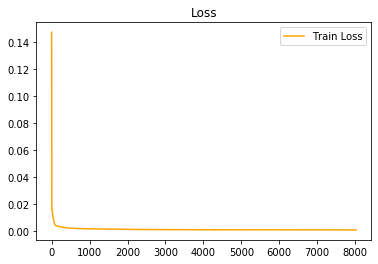

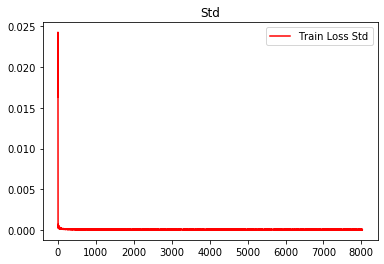

In [17]:

graph_x = []
graph_y = []

graph = plt.plot(epoch_history,epoch_loss_history, color = 'orange', label = 'Train Loss')
plt.title("Loss")
plt.legend(['Train Loss'])
plt.show()


graph_x = []
graph_y = []

graph = plt.plot(epoch_history,epoch_loss_std_history, color = 'red', label = 'Train Loss')
plt.title("Std")
plt.legend(['Train Loss Std'])
plt.show()


In [18]:


# for testing
testdata        = np.load('test.npy')
testdataset     = numpyDataset(testdata, transform)
testloader      = DataLoader(testdataset, batch_size=1, shuffle=False, num_workers=2)

result_for_submit = None    # this is for submit file

for batch_idx, data in enumerate(testloader):

    result_of_test = model(data.cuda())
    
    #print(result_of_test)
    
    if batch_idx == 0:
        result_for_submit = result_of_test
    else:
        try:
            result_for_submit = torch.cat([result_for_submit, result_of_test], dim=0)

        except RuntimeError:
            transposed = torch.transpose(result_of_test, 2, 3)
            result_for_submit = torch.cat([result_for_submit, transposed], dim=0)

            
       
result_for_submit = result_for_submit.cpu()
     


# the submit_file.shape must be (400,1,120,80) 
submit_file = result_for_submit.detach().numpy()
print("submit_file.shape :",submit_file.shape)

np.save('jesoonkang20170937_u1.npy', submit_file)
print("Test Result Save Success")



submit_file.shape : (400, 1, 120, 80)
Test Result Save Success
